## Preprocessing based on EDA
Based on Evidence from EDA I will follow this:

    1️⃣ Missing value cross-checking
    2️⃣ Outlier handling
    3️⃣ Skewness correction
    4️⃣ Feature engineering
    5️⃣ Encoding categorical
    6️⃣ Scaling numerical data
    7️⃣ Feature selection 
    8️⃣ Ready for model training
     


In [82]:

import warnings
warnings.filterwarnings("ignore")

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


## ✈️ Import data from EDA

In [83]:
data = pd.read_csv("cleaned_EDA_data.csv")
data.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [84]:
#  make a copy of the data
df= data.copy()

## 1️⃣  Missing value cross-checking

In [85]:
df.isna().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [86]:
df.prevailing_wage.tail()

25475     77092.57
25476    279174.79
25477    146298.85
25478     86154.77
25479     70876.91
Name: prevailing_wage, dtype: float64

**No missing values as expected from EDA**

##  2️⃣ Outlier handling

In [87]:
def capping_outliers(df, features:list):
    for feature in features:
        Q1=df[feature].quantile(0.25)
        Q3=df[feature].quantile(0.75)
        IQR= Q3-Q1
        lower= Q1 - 1.5 * IQR
        upper= Q3 + 1.5 * IQR
        count_outlier= ((df[feature]<lower)|(df[feature]> upper)).sum()
        df[feature]= np.where(df[feature]<lower, lower, np.where(df[feature]> upper, upper, df[feature]))
        print(f"The count of Clipped data for {feature} is: {count_outlier}")

In [88]:
# based on EDA all our numberical columns possibly have outliers
# let get our numerical columns
num_col=df.select_dtypes(include='number').columns

# now let cap them
capping_outliers(df,num_col)

The count of Clipped data for no_of_employees is: 1556
The count of Clipped data for yr_of_estab is: 3260
The count of Clipped data for prevailing_wage is: 427


In [89]:
df.prevailing_wage.tail()

25475     77092.57000
25476    218315.56125
25477    146298.85000
25478     86154.77000
25479     70876.91000
Name: prevailing_wage, dtype: float64

## 3️⃣ Feature engineering

In [90]:
# let do feauture engineering from our numerical data
num_col
# we have ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
df['emp_per_years_estab']= df['no_of_employees']/ df['yr_of_estab']
df['wage_per_employee']= df['prevailing_wage']/ df['no_of_employees']



## 4️⃣ Skewness correction

In [ ]:
# from the EDA prevailing_wage and no_of_employees are rightly skew, so log transformation is suggested
def handle_skewness(df, features:list, threshold=0.1):
    df=df.copy()
    f_log=[]
    f_square=[]
    f_moderate=[]
    for feature in features:
        skew_val=df[feature].skew()
        if skew_val> threshold:
            # right skew use log1p
            df[feature]= np.log1p(df[feature])
            f_log.append(feature) # to keep track of features that are log1p
        elif skew_val < -threshold:
            # left skewed use square scalling
            df[feature]= np.square(df[feature])
            f_square.append(feature) # to keep track of features that are f_square
        else:
            f_moderate.append(feature)

    # print feature that was transfromed
    if f_log:
        print(f"{f_log} is/are right skew and was log1p transformed")

    if f_square:
        print(f"{f_square} is/are left skew and was square transformed")

    if f_moderate:
        print(f"{f_moderate} is/are moderately skew and no transformation needed")  
    

In [92]:
# calling the function let pass all our numeric data in
handle_skewness(df,num_col)

['no_of_employees', 'prevailing_wage'] is/are right skew and was log1p transformed
['yr_of_estab'] is/are left skew and was square transformed


In [93]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,emp_per_years_estab,wage_per_employee
0,Asia,High School,N,N,7227.0,2007.0,West,592.2029,Hour,Y,Denied,3.600897,0.081943
1,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,Certified,1.204795,34.587749
2,Asia,Bachelor's,N,Y,7227.0,2008.0,West,122996.8600,Year,Y,Denied,3.599104,17.019076
3,Asia,Bachelor's,N,N,98.0,1932.5,West,83434.0300,Year,Y,Denied,0.050712,851.367653
4,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,Certified,0.539651,138.546571


##  5️⃣ Encoding categorical

In [94]:
# let get our categorical data
cat_col=df.select_dtypes(include='object').columns
cat_col

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [95]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Binary encoding function
def label_encode(df, features):
    df = df.copy()
    le = LabelEncoder()
    for feature in features:
        df[feature] = le.fit_transform(df[feature])
    print("------ Label Encoding Complete ------")
    return df

# OneHot encoding function
def onehot_encode(df, features):
    df = df.copy()
    ohe = OneHotEncoder(sparse_output=False, drop='first') 
    encoded = ohe.fit_transform(df[features])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(features), index=df.index)
    df = pd.concat([df.drop(columns=features), encoded_df], axis=1)
    print("------ One-Hot Encoding Complete ------")
    return df

In [96]:
# let encode our binary cat
binary_cat = ['has_job_experience', 'requires_job_training', 'full_time_position', 'case_status']
df = label_encode(df, binary_cat)

------ Label Encoding Complete ------


In [97]:

# let encode our multi-cat
multi_cat = [f for f in cat_col if f not in binary_cat]
df = onehot_encode(df, multi_cat)

------ One-Hot Encoding Complete ------


In [98]:
# let view our data
df.head(5)


,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,prevailing_wage,full_time_position,case_status,emp_per_years_estab,wage_per_employee,continent_Asia,...,education_of_employee_Doctorate,education_of_employee_High School,education_of_employee_Master's,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,0,0,7227.0,2007.0,592.2029,1,1,3.600897,0.081943,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,2412.0,2002.0,83425.6500,1,0,1.204795,34.587749,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,1,7227.0,2008.0,122996.8600,1,1,3.599104,17.019076,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,0,98.0,1932.5,83434.0300,1,1,0.050712,851.367653,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,1082.0,2005.0,149907.3900,1,0,0.539651,138.546571,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 6️⃣ Scaling numerical data

In [99]:
# Based on the evidence from EDA that
# numerical data has extremely higher values(possibly outliers)
# RoburstSacaler is recommended

# fuction for scaling
def rb_scalling(df,features:list):
    df=df.copy()
    for feature in features:
        df[feature]= RobustScaler().fit_transform(df[[feature]])
    print("------ Robust Scaling Complete ------")

# let scale our numerical data
rb= RobustScaler()
rb_scalling(df,num_col)
df.head(5)

------ Robust Scaling Complete ------


,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,prevailing_wage,full_time_position,case_status,emp_per_years_estab,wage_per_employee,continent_Asia,...,education_of_employee_Doctorate,education_of_employee_High School,education_of_employee_Master's,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,0,0,7227.0,2007.0,592.2029,1,1,3.600897,0.081943,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,2412.0,2002.0,83425.6500,1,0,1.204795,34.587749,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,1,7227.0,2008.0,122996.8600,1,1,3.599104,17.019076,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,0,98.0,1932.5,83434.0300,1,1,0.050712,851.367653,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,1082.0,2005.0,149907.3900,1,0,0.539651,138.546571,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 7️⃣ Feature selection 

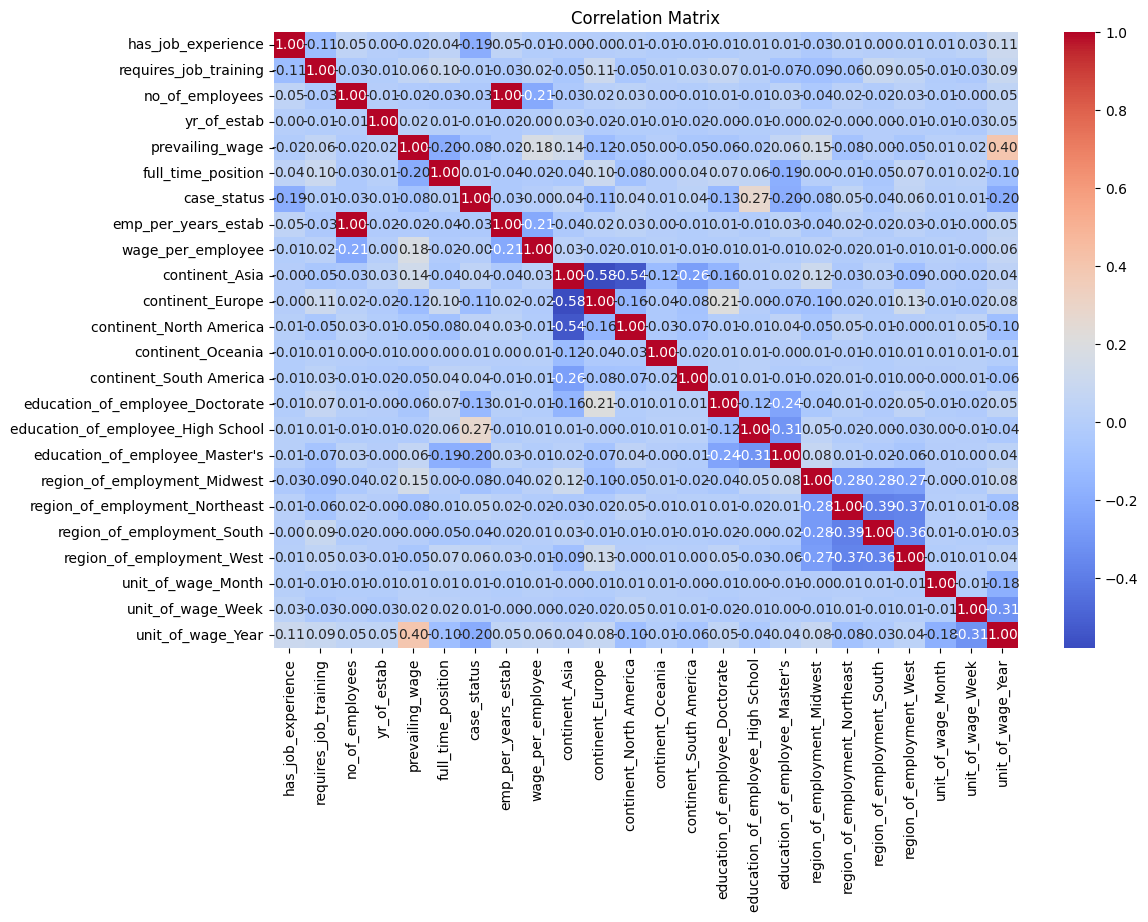

Selected features based on correlation with 'case_status': ['has_job_experience', 'continent_Europe', 'education_of_employee_Doctorate', 'education_of_employee_High School', "education_of_employee_Master's", 'unit_of_wage_Year']


['has_job_experience',
 'continent_Europe',
 'education_of_employee_Doctorate',
 'education_of_employee_High School',
 "education_of_employee_Master's",
 'unit_of_wage_Year']

In [100]:
# fucntion selecting features using correlation matrix,with correlation greater than 0.1 with target variable 'case_status'
target_variable='case_status'
def feature_selection_corr(df, target_variable, threshold=0.1):
    df=df.copy()
    corr_matrix= df.corr()
    target_corr= corr_matrix[target_variable].abs()
    # let visualize the correlation matrix before selecting features
    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

    # select features based on threshold
    selected_features= target_corr[target_corr> threshold].index.tolist()
    selected_features.remove(target_variable)  # remove target variable from the list
    print(f"Selected features based on correlation with '{target_variable}': {selected_features}")
    return selected_features

# let get our selected features
selected_features= feature_selection_corr(df, target_variable, threshold=0.1)
selected_features

## 8️⃣ Ready for model training

In [101]:
# let check our final dataframe before model training
final_df= df[selected_features + [target_variable]]
final_df.head(5)

,has_job_experience,continent_Europe,education_of_employee_Doctorate,education_of_employee_High School,education_of_employee_Master's,unit_of_wage_Year,case_status
0,0,0.0,0.0,1.0,0.0,0.0,1
1,1,0.0,0.0,0.0,1.0,1.0,0
2,0,0.0,0.0,0.0,0.0,1.0,1
3,0,0.0,0.0,0.0,0.0,1.0,1
4,1,0.0,0.0,0.0,1.0,1.0,0


In [102]:
# let set our data for model training
X= df[selected_features]
y= df[target_variable]

# let split our data to first level split
X_train, X_temp, y_train, y_temp= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_temp.shape, y_train.shape, y_temp.shape  

# second level split for validation and test set
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

# let save our processed data to csv
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# let save our selected features as pkl file
import pickle
with open("selected_features.pkl", "wb") as f:
    pickle.dump(selected_features, f)

print("Processed data saved to CSV files.")

Processed data saved to CSV files.
